# Time series classification for fault detection in thermoforming machines

<font color=red>This project was part of a university seminar in cooperation with an industry partner. The data is confidential and I am not allowed to share it. I left sample data for every group, so you are able to follow the code.</font>

***

## Thermoforming example
![Thermoforming](https://pri-plastics.com/wp-content/uploads/2020/06/Thermoforming-Process.jpg)

## Task description
The aim of this project is "inline" detection of incomplete molded products (e. g. of yoghurt cups) based on the pressure curve. The aim is not *early time series classification*, because the molding a product only take a short amount of time and cannot be interrupted.

The data gathered during an experiment and contains measurements from different sensors. Only the pressure sensor data should be used. The sensor has a sampling rate of 1ms. 

Four different classes of outcomes were present:
1. Group A - not formed *(Ger.: Gruppe A - nicht ausgeformt)*
2. Group B - without bottom *(Ger.: Gruppe B - ohne Boden)*
3. Group B - incomplete bottom *(Ger.: Gruppe B - Boden berührt)*
4. Group A - formed *(Ger.: Gruppe A - ausgeformt)*

The class **formed** means that there is a complete mapping of the outer shape contour of the molded part.

The class **not formed** means that the foil was not heated and therefore not formed. 

The class **without bottom** denotes molded parts which have been formed but have not reached the bottom of the mold. Therefore they are  incompletely formed.

The class **incomplete bottom** also designates incompletely formed molded parts, but the bottom of the molded part has been reached. However, the molding does not extend completely into the mold.

So the only desirable outcome is correctly **formed** product. The other three classes represent faults of different severity. In the above the classes are sorted by severity.

## Setup

### virtual enviroment and packages
Use OS level shell to setup the enviroment. Setup in the correct folder!
Please use python 3.10. Package sktime does not work with 3.11 at the moment.

In [69]:
# Guide: How to use virtual env with jupyter: https://codemuch.net/posts/vscode_jupyter_notebook/
# pip install virtualenv
# python -m virtualenv rocket
# rocket\Scripts\activate
# pip install ipykernel 
# python -m ipykernel install --user --name=rocket

### install and activate packages
importing Rocket may take some time during the first import

In [70]:
#pip install pandas numpy matplotlib tensorflow sktime[all_extras] keras attrs

In [112]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split

from sktime.pipeline import make_pipeline
from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.impute import Imputer
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.rocket import MiniRocket

In [72]:
# Set random seed
seed = 3333
np.random.seed(seed)

# Suppress scientific notation
np.set_printoptions(suppress = True)

## Pre-Processing

### Read files from different directories

My goal is to detect faulty products based on the pressure curve. But the machine is doing other tasks, e. g. heating plastic, opening or closing. But the only task I am interested in is the forming of products. The current state of the machine is logged and I am only reading the necessary rows from each trial based on this information. It is available in the column "task name" (Ger.: "Zustandsname") and the task is called "S5: Processing Forming" (Ger.: S5: Bearbeitung Formen).

In [73]:
df = []

paths = ["./data/Gruppe A/Zustand ausgeformt", "./data/Gruppe A/Zustand nicht ausgeformt", "./data/Gruppe B/nicht vollst ausgeformt - ohne Boden", "./data/Gruppe B/nicht vollst ausgeformt - Boden berührt"]

for idx, path in enumerate(paths):

    all_files = glob.glob(path + "/*.csv")

    for filename in all_files:
        li = (pd.read_csv(filename, encoding="latin-1", sep=";", header=0, usecols=[0,1,5], index_col=None) 
            [lambda x: x["Zustandsname"] == "S5: Bearbeitung Formen"])
        li = li.drop(["Zustandsname"], axis=1) 
        li["group"] = idx
        li["id"] = os.path.basename(filename)
        li["id"] = li["id"].str.slice(5,8).astype("int")
        df.append(li)

# Create the complete data frame
df = pd.concat(df, axis=0, ignore_index=True)

### Clean imported data
I add headers, rename columns and transform the timestamps to seconds since the start of a experimental trial.

In [74]:
# Transform the timestamp
df.columns = df.columns.str.replace("Unnamed: 0", "timestamp")
df["timestamp"] = df["timestamp"].astype("str")
df.loc[~df["timestamp"].str.contains(pat = "\."),"timestamp"] = df["timestamp"] + ".000000"
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%H:%M:%S.%f", exact=False)

# Transform the timestamp to milliseconds since start
milliseconds = df.groupby("id").apply(lambda x: x.timestamp - x.iloc[0,0]).to_frame(name = "milliseconds")
milliseconds = milliseconds.reset_index()
milliseconds = milliseconds.set_index("level_1") 
merged = df.join(milliseconds, how="left", lsuffix="_left", rsuffix="_right")
merged["milliseconds"] = merged["milliseconds"].dt.total_seconds() * 1e3
merged["milliseconds"] = merged["milliseconds"].astype("int")

# Clean dataframe
merged = merged.drop(["timestamp", "id_right"], axis=1) 
merged.rename(columns={"id_left": "id", "Druck Formwerkzeug": "pressure"}, inplace=True)

# Replace groupe int with strings
merged["group"] = merged["group"].replace([0, 1, 2, 3], ["formed", "not formed", "without bottom", "incomplete bottom"])

# Sort the columns
merged = merged[["id", "group", "milliseconds", "pressure"]]
merged.sort_values(by=["id", "milliseconds"], inplace=True, ascending = True)

# Rename merged to df
df = merged

In [75]:
df

,id,group,milliseconds,pressure
0,2,formed,0,0.006
1,2,formed,1,0.006
2,2,formed,2,0.000
3,2,formed,3,0.017
4,2,formed,4,0.001
...,...,...,...,...
758285,230,without bottom,4997,1.460
758286,230,without bottom,4998,1.461
758287,230,without bottom,4999,1.465
758288,230,without bottom,5000,1.459


In [76]:
df.dtypes

id                int32
group            object
milliseconds      int32
pressure        float64
dtype: object

### Remove outliers 
Pressure curves have to start at ~0. If not the measurement start was delayed and I have to remove the trial. SO i just check for trials that start with a value greater than 1.

In [77]:
# Get the IDs of outliers
outliers = df.groupby("id")["pressure"].first() >= 1
outliers = outliers[outliers == True].index.values

# Remove the outliers
df = df[df.id.isin(outliers) == False]

print("Removed trials: ", outliers)

Removed trials:  [49 69]


## Explore data

Get number of cases per group.

In [78]:
df.groupby("group")["id"].nunique()

group
formed               49
incomplete bottom    55
not formed           49
without bottom       53
Name: id, dtype: int64

### Descriptive statistics for pressure and time

In [79]:
df.groupby(["group"]).agg({"pressure": ["count", "mean", "min", "max", "var"]})

pressure                                
                     count      mean  min    max       var
group                                                     
formed              243597  3.831113  0.0  4.055  0.450401
incomplete bottom   273770  1.659010  0.0  4.012  0.572121
not formed          241990  3.828530  0.0  4.058  0.443569
without bottom      264669  1.981515  0.0  5.131  1.725147

In [80]:
df.groupby(["group"]).agg({"milliseconds": ["count","mean", "min", "max", "var"]})

milliseconds                                     
                         count         mean min   max           var
group                                                              
formed                  243597  2503.996786   0  5002  2.094966e+06
incomplete bottom       273770  2491.562472   0  5003  2.078096e+06
not formed              241990  2506.212439   0  5003  2.090505e+06
without bottom          264669  2496.720288   0  5002  2.079853e+06

Plot all trials (is possible because of the small number)

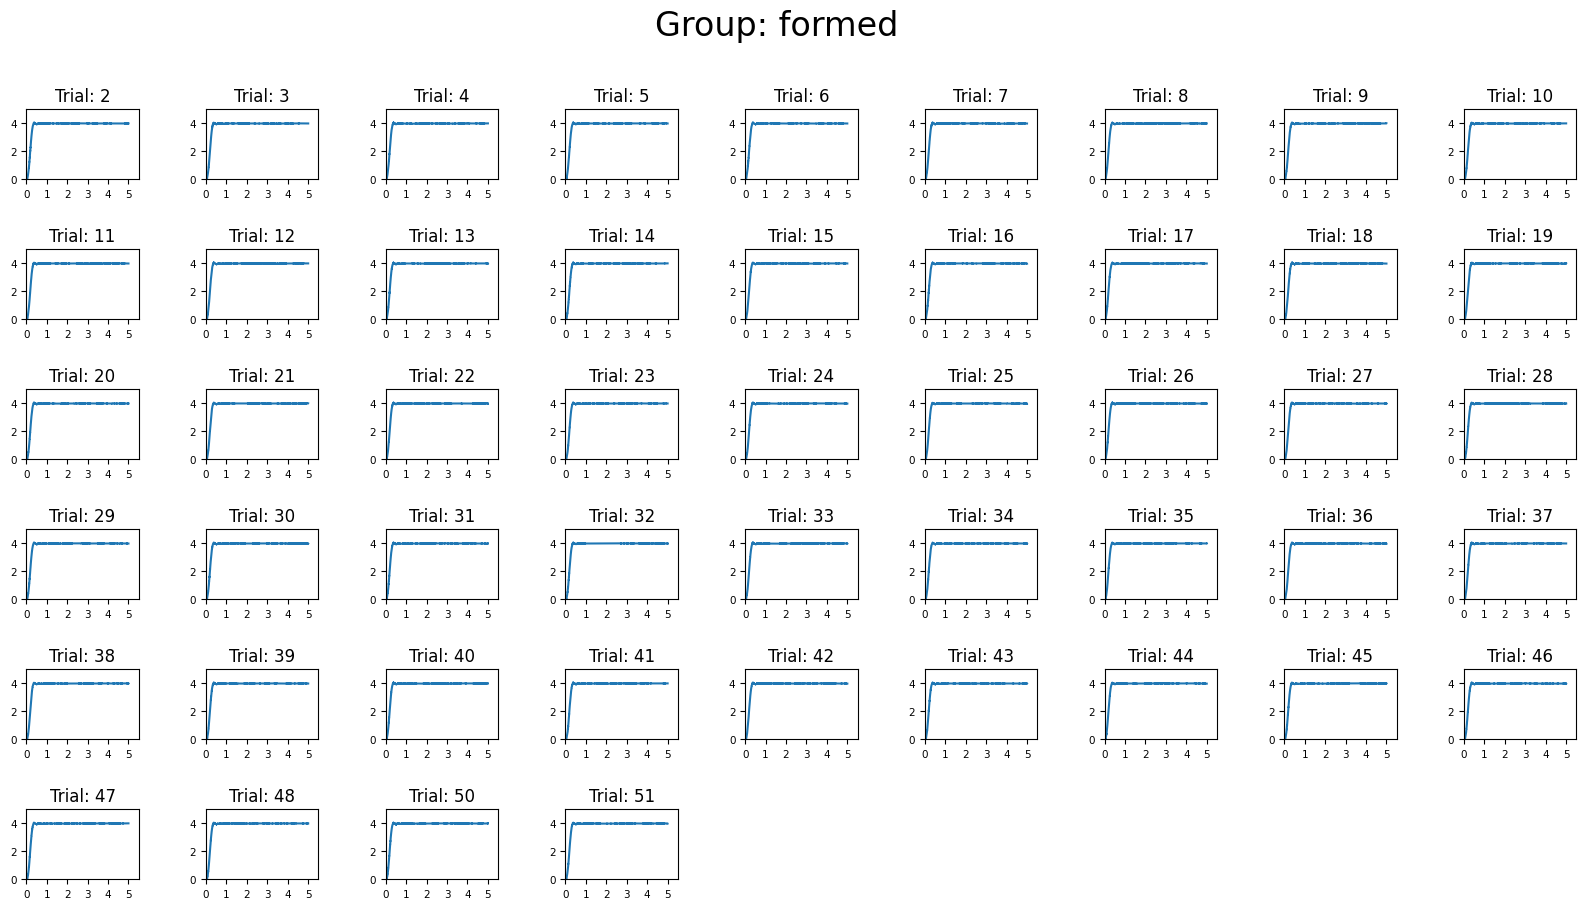

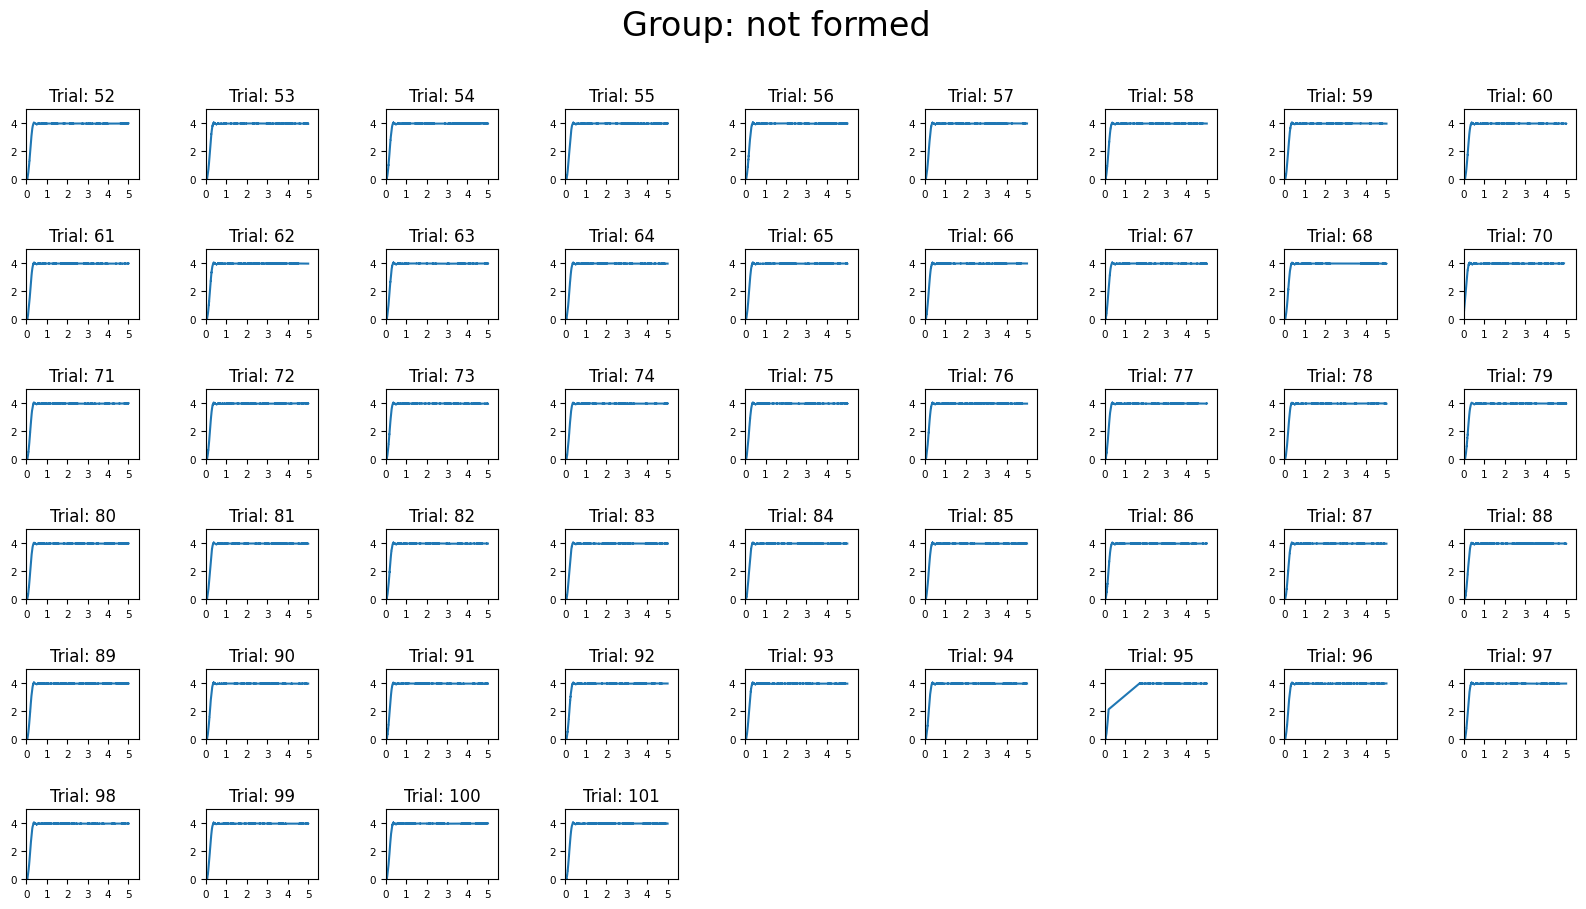

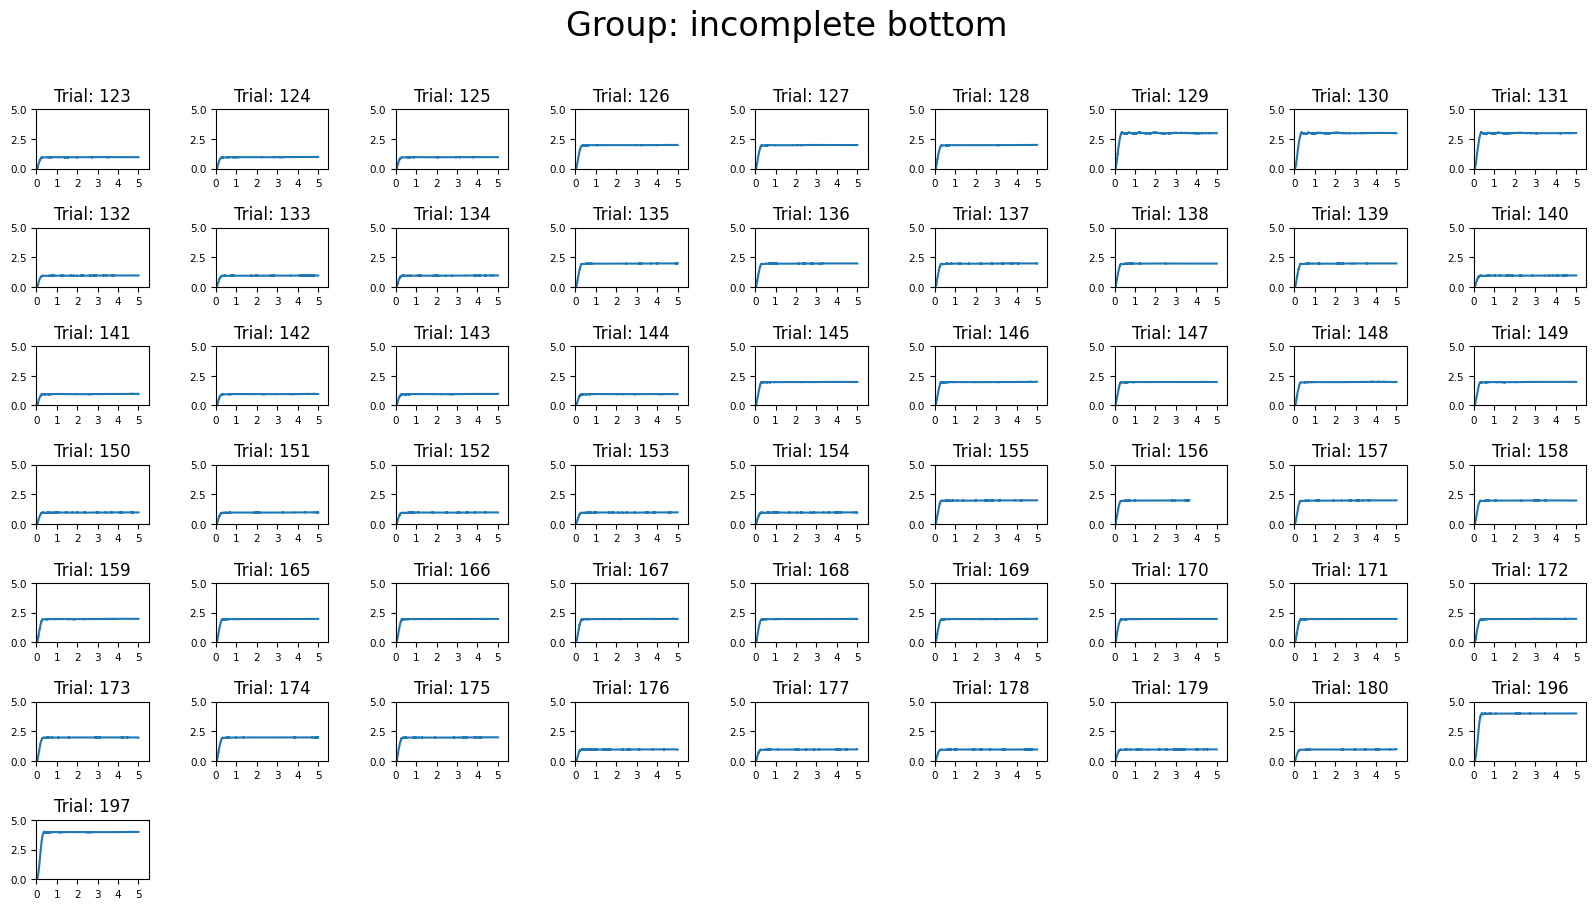

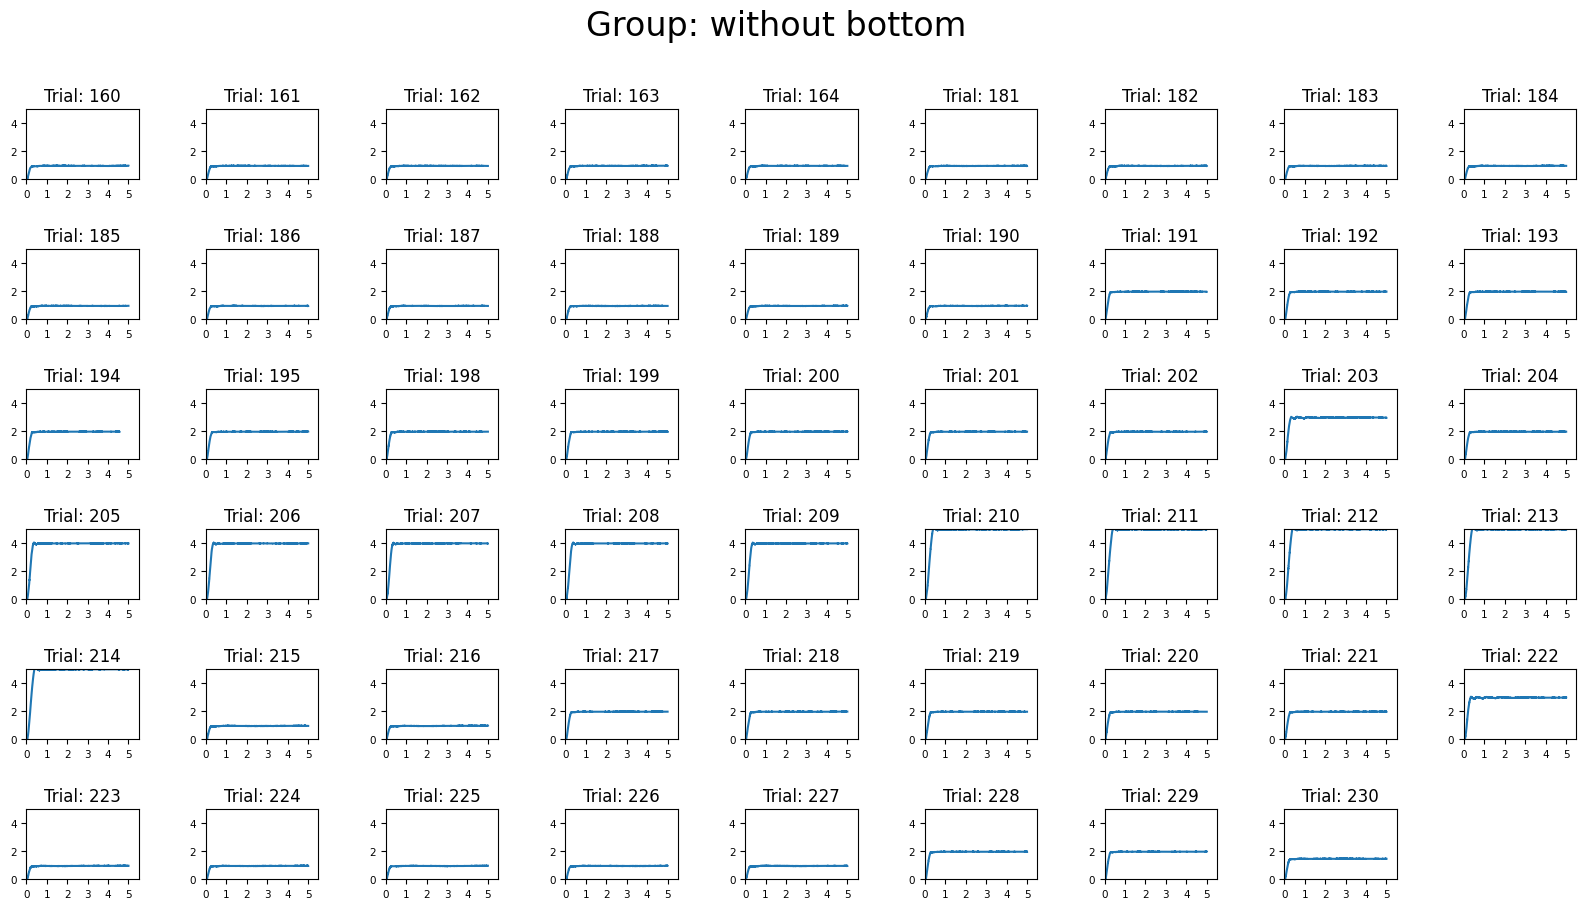

In [81]:
# Add seconds for plotting
df = df.assign(seconds=lambda x: x.milliseconds /1000)

# One plot for each group
groups = df["group"].unique()

for group in groups:

    # Get a dataframe for each group
    temp_df = df[df["group"] == group]

    # Get a list of all ids
    ids = temp_df["id"].unique()

    # Dynamically calculate the rows for a fixed number of columns
    ncols = 9
    nrows = len(ids) // ncols + (len(ids) % ncols > 0)

    plt.figure(figsize=(20, 10))
    plt.subplots_adjust(wspace=0.6, hspace=1)
    plt.suptitle("Group: " + str(group), fontsize=24)

    for n, id in enumerate(ids):

        ax = plt.subplot(nrows, ncols, n + 1)

        temp_df[temp_df["id"] == id].plot(ax=ax, x = "seconds", y ="pressure")

        # Formatting
        ax.set_title("Trial: " + str(id))
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_xlim([0, 5.5])
        ax.set_ylim([0, 5])
        ax.tick_params(axis="both", which="major", labelsize=7.5)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Drop seconds after plotting
df.drop("seconds", axis=1, inplace=True)

### Length of time series data
To work with time series data we need equal length and no missing values.

In [82]:
df_count = df.groupby(["id", "group"])["id"].count()
df_count.groupby("group").agg(["median", "mean","min", "max"])

,median,mean,min,max
group,,,,
formed,5002.0,4971.367347,3501,5003
incomplete bottom,5002.0,4977.636364,3658,5003
not formed,5002.0,4938.571429,3501,5003
without bottom,5002.0,4993.754717,4565,5003


Plot the number of cases against the maximum number of seconds in a 2d histogram plot. So we do not have to do an additional scatter plot to see if maximum number of observation and the time in seconds are equal. If they are not equak we have trials where the sensor failed.

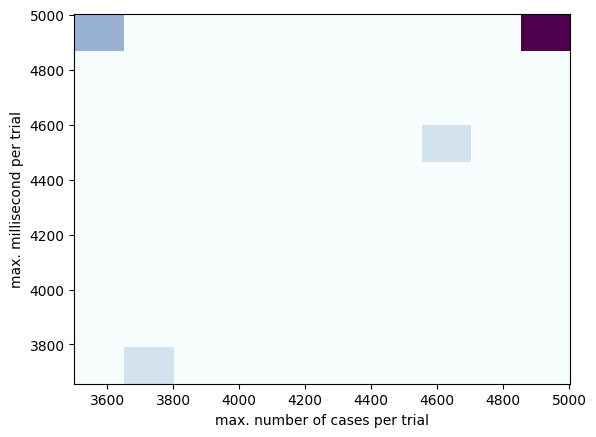

In [83]:
maxtime = df.groupby(["id", "group"])[["milliseconds"]].max()

plt.hist2d( df_count.to_numpy(), maxtime["milliseconds"].to_numpy(), cmin=0, bins=(10, 10), norm="symlog", cmap=plt.cm.BuPu)
plt.xlabel('max. number of cases per trial')
plt.ylabel('max. millisecond per trial')
plt.show()

We can see that we  have a few trials with less then 5000 measurements, so we want to look at these.

In [84]:
df_count = df_count[df_count < 5000]
incomplete_ids = df_count.index.get_level_values(0)

Visually inspect the time series for the six trials, to determine how we can deal with the unequal length.

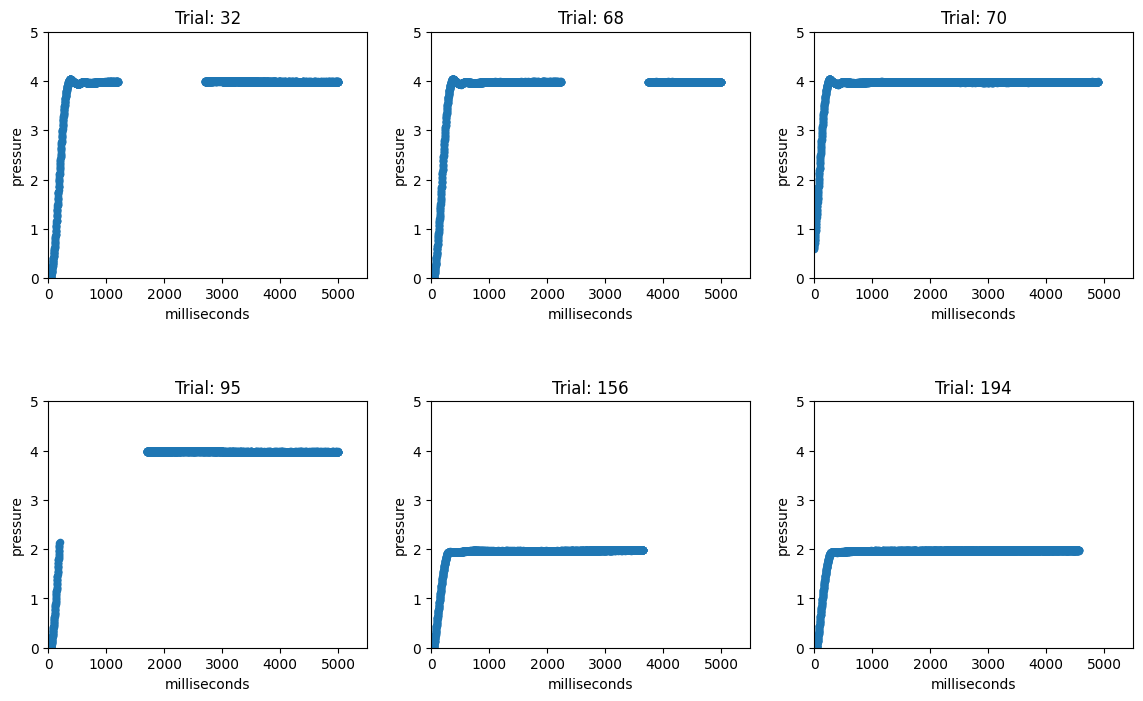

In [85]:
plt.figure(figsize=(14, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for n, id in enumerate(incomplete_ids):

    ax = plt.subplot(2, 3, n + 1)

    df[df["id"] == id].plot(ax=ax, x = "milliseconds", y ="pressure", kind="scatter")

    # Formatting
    ax.set_title("Trial: " + str(id))
    ax.set_xlim([0, 5500])
    ax.set_ylim([0, 5])

### Summary of the exploration 
- Each group contains ~50 trials.
- Descriptive analysis shows differences between the groups. 
- The shape of the pressure curve is similar for all groups, but for groups 2 and 3 the plateau is higher/lower compared to group 0 and 1.
- Most trials have ~5000 measures, but six trials are shorter. 


## Prepare data for modelling

### Pad time series
As shown before the length of the time series varies around 5000ms. Moreover a few trials have incomplete data. That is important because the time series classification algorithms I am going to use require equal-length time series. Moreover `sktime` uses 3d numpy arrays and unequal length data is not possible in `numpy`. `sktime` offers various options to pad or impute a time series, which we are going to implement in our model, but for that we need NaN's.

I start by checking if I have any consecutive time series at all. I want to be sure that the sensor really measured every millisecond.

In [86]:
def checkConsecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))

checkConsecutive(df["milliseconds"].unique())

False

I do not have any consecutive time series. So I  create an array that is equal to the maximal possible milliseconds and search for missing values. 

In [87]:
rng = np.arange(0,df["milliseconds"].max() + 1)

diff = list(set(rng) - set(df["milliseconds"].unique()))

print("Number of missing milliseconds:", len(diff))

Number of missing milliseconds: 48


Now I create a skeleton dataframe with continuos milliseconds from 0 to 5003ms. That is merged with the existing dataframe to add NaN for missing rows.

In [88]:
# Create a skeleton frame
ids = df["id"].unique().tolist()
index = pd.MultiIndex.from_product([ids,rng], names=["id", "milliseconds"])
skeleton = pd.DataFrame(index=index)

# Set multiindex on the current frame
df.set_index(['id', 'milliseconds'], inplace=True)

# Merge both datasets
df = df.merge(skeleton, how='outer', left_index=True, right_index=True)

# Print
df

group  pressure
id  milliseconds                          
2   0                     formed     0.006
    1                     formed     0.006
    2                     formed     0.000
    3                     formed     0.017
    4                     formed     0.001
...                          ...       ...
230 4999          without bottom     1.465
    5000          without bottom     1.459
    5001          without bottom     1.460
    5002                     NaN       NaN
    5003                     NaN       NaN

[1045108 rows x 2 columns]

### Create variables
For some some reason sktime is not able to handle 2d numpy arrays. The easiest way forward is transforming to an 3d numpy array.

In [89]:
wide = df.pivot_table(index=["id"], 
                    columns=["milliseconds"], 
                    values="pressure",
                    dropna=False).reset_index()

wide.drop(['id'], axis=1, inplace=True)

X = wide.to_numpy()

# to 3d numpy
X = X.reshape((X.shape[0], X.shape[1],1))
X = X.reshape((X.shape[0],1, X.shape[1]))

This categorical variable with four groups is coded as follows:
| Level        | Group                       | 
|--------------|-----------------------------|
| 0            | Group A - formed            | 
| 1            | Group A - not formed        |
| 2            | Group B - without bottom    |
| 3            | Group B - incomplete bottom |

In [90]:
# Create the target and cleanup the categories
y_text = df.groupby("id")["group"].unique()
y_text = pd.Series(map(lambda x: np.array_str(x), y_text))
y_text = pd.Series(map(lambda x: x.replace("'","").replace('"','').replace("[","").replace("]",""), y_text))

# Four groups
y = pd.factorize(y_text)[0]

# Binary classification
y_binary = np.where(np.isin(y, 2), 1, y)
y_binary = np.where(np.isin(y, 3), 1, y_binary)

## Modelling
I split into train and test data. Because the sample size is small I am using stratified 5 fold cross validation on the training data. See below for an illustration (only 3 folds):

````
|---- train ------------------|- validation -|         |--- test ---|
|---- train ---|- validation -|---- train ---|         |--- test ---|
|- validation -|----------- train -----------|         |--- test ---|

````
I am going to compare three different algorithms:
1. One nearest neighbor (1-NN) classification
2. ROCKET
3. miniROCKET

One nearest neighbor (1-NN) classification with Dynamic Time Warping (DTW) is a old time series classification approach and a common performance benchmark.

ROCKET transforms input time series using a large number of fixed, non-trainable, independent convolution kernels. Based on these transformed features a simple linear classifier is trained. In comparison to other approaches ROCKET is computationally inexpensive. As suggested by the authors of ROCKET I am using sklearn's `RidgeClassifierCV` for a small sample. miniROCKET is a enhanced version of ROCKET that is significantly faster and should be more accurate.

Moreover I am using `sklearn`'s `DummyClassifier` for comparison. 

**Papers:**
- Dempster, A., Petitjean, F., & Webb, G. I. (2020). ROCKET: exceptionally fast and accurate time series classification using random convolutional kernels. Data Mining and Knowledge Discovery, 34(5), 1454-1495.
- Dempster, A., Schmidt, D. F., & Webb, G. I. (2021, August). Minirocket: A very fast (almost) deterministic transform for time series classification. In Proceedings of the 27th ACM SIGKDD conference on knowledge discovery & data mining (pp. 248-257).


### Define cross validation settings

In [91]:
from sklearn.metrics import make_scorer

In [92]:
# Stratified 5 fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Set scoring parameters
scoring = "accuracy", "precision" , "recall"

scoring = {
            'precision': make_scorer(precision_score, average='micro'),
            'recall': make_scorer(recall_score, average='micro'),
            'accuracy': make_scorer(accuracy_score)
          }

# Set a function to print the same evaluation metrics for each model
def cv_evaluation(scores):

    accuracy = "Accuracy: {m:0.2f}% (SD = {std:0.2f}%)".format(m = scores["test_accuracy"].mean()*100, 
                                                    std = scores["test_accuracy"].std()*100 )

    sensitivity = "Sensitivity (true positive rate): {m:0.2f}% (SD = {std:0.2f}%)".format(m = scores["test_recall"].mean()*100, 
                                                                                      std = scores["test_recall"].std()*100 ) 

    ppv = "Positive Predictive Value (Precision): {m:0.2f}% (SD = {std:0.2f}%)".format(m = scores["test_precision"].mean()*100, 
                                                                            std = scores["test_precision"].std()*100 )

    score_time = "Score Time: {sum:0.2f}s".format(sum = scores["score_time"].sum())
    
    fit_time = "Fit Time: {sum:0.2f}s".format(sum = scores["fit_time"].sum())

    print(accuracy)
    print(sensitivity)
    print(ppv)
    print("---")
    print(score_time)
    print(fit_time)

### Define Pipelines/Models

The hyperparameters for the one nearest neighbor (1-NN) classification are based on simple grid search conducted several month ago. I am re-running this notebook on my local machine, which is no very performant. Moreover miniROCKET is much more efficient, so using a expensive grid search is not reasonable. Times series specific distance measures like `dtw` are computational quite expensive.

To reduce ROCKET's to computation time I am reducing the number of kernels from 10,000 (default) to 2,000 and miniRockets to 5,000. `sktime` offers a wrapper called `RocketClassifier` for the different ROCKET algorithms, that combines Rocket with a `StandardScaler`  and a `RidgeClassifierCV`, but for readability I am not using it.

Missing values are imputed using using `sktime`'s `drift` method which uses a polynomial regression regression to forecast the missing value.

In [93]:
# Dummy Classifier
dummy_pipe = make_pipeline(
    DummyClassifier(strategy="prior", random_state=seed)
)

# One nearest neighbor (1-NN) classification
kneighbors_pipe = make_pipeline(
    FitInTransform(Imputer(method="drift", random_state=seed)),
    KNeighborsTimeSeriesClassifier(weights="distance", n_neighbors=7, distance="squared", algorithm="brute")
)

# ROCKET
rocket_pipe = make_pipeline(
    FitInTransform(Imputer(method="drift", random_state=seed)),
    Rocket(num_kernels=2000, random_state=seed),
    StandardScaler(with_mean=False),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
)

# miniROCKET
minirocket_pipe = make_pipeline(
    FitInTransform(Imputer(method="drift", random_state=seed)),
    MiniRocket(num_kernels=5000, random_state=seed),
    StandardScaler(with_mean=False),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
)

### Binary classification

#### Train-Test-Split

In [94]:
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(X,y_binary, stratify=y_binary, test_size=0.25, shuffle=True, random_state=seed)

print("Shape of training data:", y_binary_train.shape)
print("Shape of test data:", y_binary_test.shape)

Shape of training data: (154,)
Shape of test data: (52,)


#### Baseline

In [95]:
dummy_scores = cross_validate(dummy_pipe, X_binary_train, y_binary_train, cv=skf, scoring=scoring, return_estimator=True)

cv_evaluation(dummy_scores)

Accuracy: 75.98% (SD = 1.48%)
Sensitivity (true positive rate): 75.98% (SD = 1.48%)
Positive Predictive Value (Precision): 75.98% (SD = 1.48%)
---
Score Time: 0.02s
Fit Time: 0.03s


#### KNeighborsTimeSeriesClassifier

In [96]:
kneighbors_scores = cross_validate(kneighbors_pipe, X_binary_train, y_binary_train, cv=skf, scoring=scoring, return_estimator=False)

cv_evaluation(kneighbors_scores)

Accuracy: 92.19% (SD = 1.66%)
Sensitivity (true positive rate): 92.19% (SD = 1.66%)
Positive Predictive Value (Precision): 92.19% (SD = 1.66%)
---
Score Time: 13.69s
Fit Time: 58.51s


#### ROCKET

In [97]:
rocket_scores = cross_validate(rocket_pipe, X_binary_train, y_binary_train, cv=skf, scoring=scoring, return_estimator=True)

cv_evaluation(rocket_scores)

Accuracy: 97.42% (SD = 3.16%)
Sensitivity (true positive rate): 97.42% (SD = 3.16%)
Positive Predictive Value (Precision): 97.42% (SD = 3.16%)
---
Score Time: 50.77s
Fit Time: 408.46s


#### miniROCKET

In [98]:
minirocket_scores = cross_validate(minirocket_pipe, X_binary_train, y_binary_train, cv=skf, scoring=scoring, return_estimator=True)

cv_evaluation(minirocket_scores)

Accuracy: 97.40% (SD = 2.42%)
Sensitivity (true positive rate): 97.40% (SD = 2.42%)
Positive Predictive Value (Precision): 97.40% (SD = 2.42%)
---
Score Time: 23.22s
Fit Time: 180.67s


#### Use best model on test data
Looking at the results we see that `miniROCKET` performs very well and is much faster than ROCKET. This is expected, because miniROCKET is more efficient than ROCKET. I re-train the model on the complete training data and test it using the held out data.

In [99]:
minirocket_pipe.fit(X_binary_train, y_binary_train)
y_binary_pred = minirocket_pipe.predict(X_binary_test)

accuracy_score(y_binary_test, y_binary_pred)

1.0

In [100]:
print(classification_report(y_binary_test, y_binary_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        40

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



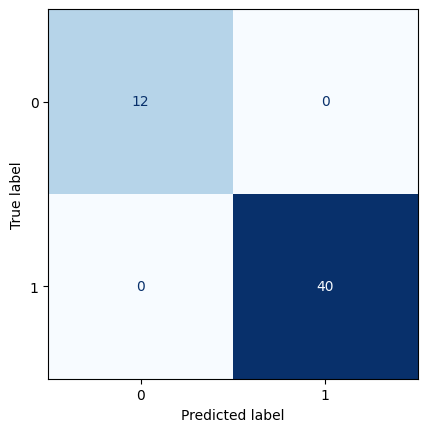

In [101]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_binary_test,
    y_binary_pred,
    cmap=plt.cm.Blues,
    colorbar=False,
)

plt.show()

### Classification with all four groups
For that we just redo the models from above but we use the data that contains all four groups. At this point stratification becomes important.

#### Train Test Split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, shuffle=True, random_state=seed)

print("Shape of training data:", y_train.shape)
print("Shape of test data:", y_test.shape)

Shape of training data: (154,)
Shape of test data: (52,)


#### Baseline

In [103]:
dummy_scores = cross_validate(dummy_pipe, X_train, y_train, cv=skf, scoring=scoring, return_estimator=True)

cv_evaluation(dummy_scores)

Accuracy: 26.62% (SD = 1.25%)
Sensitivity (true positive rate): 26.62% (SD = 1.25%)
Positive Predictive Value (Precision): 26.62% (SD = 1.25%)
---
Score Time: 0.02s
Fit Time: 0.01s


#### KNeighborsTimeSeriesClassifier

In [104]:
kneighbors_scores = cross_validate(kneighbors_pipe, X_train, y_train, cv=skf, scoring=scoring, return_estimator=False)

cv_evaluation(kneighbors_scores)

Accuracy: 84.43% (SD = 5.51%)
Sensitivity (true positive rate): 84.43% (SD = 5.51%)
Positive Predictive Value (Precision): 84.43% (SD = 5.51%)
---
Score Time: 13.27s
Fit Time: 56.07s


### ROCKET

In [105]:
rocket_scores = cross_validate(rocket_pipe, X_train, y_train, cv=skf, scoring=scoring, return_estimator=True)

cv_evaluation(rocket_scores)

Accuracy: 85.74% (SD = 4.77%)
Sensitivity (true positive rate): 85.74% (SD = 4.77%)
Positive Predictive Value (Precision): 85.74% (SD = 4.77%)
---
Score Time: 49.83s
Fit Time: 405.18s


### miniROCKET

In [106]:
minirocket_scores = cross_validate(minirocket_pipe, X_train, y_train, cv=skf, scoring=scoring, return_estimator=True)

cv_evaluation(minirocket_scores)

Accuracy: 89.63% (SD = 2.35%)
Sensitivity (true positive rate): 89.63% (SD = 2.35%)
Positive Predictive Value (Precision): 89.63% (SD = 2.35%)
---
Score Time: 22.92s
Fit Time: 178.86s


#### Use the best model on test data
As before miniROCKET is the best approach for the problem at hand. I re-train the model on the complete training data and test it using our held out data.

In [107]:
minirocket_pipe.fit(X_train, y_train)
y_pred = minirocket_pipe.predict(X_test)

accuracy_score(y_test, y_pred)

0.9423076923076923

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      1.00      1.00        12
           2       1.00      0.86      0.92        14
           3       0.93      0.93      0.93        14

    accuracy                           0.94        52
   macro avg       0.95      0.95      0.94        52
weighted avg       0.95      0.94      0.94        52



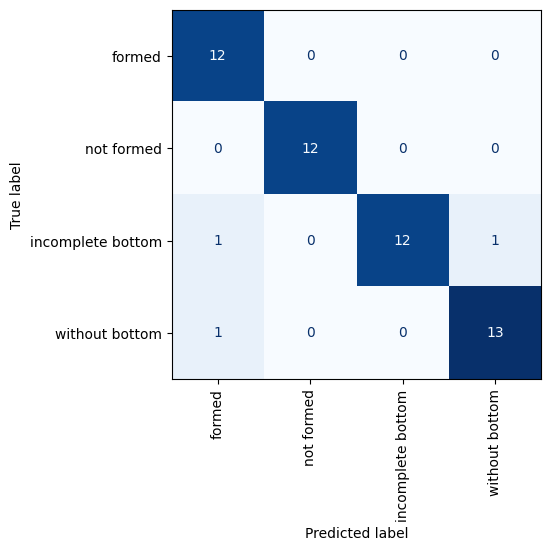

In [111]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=df["group"].dropna().unique(),
    xticks_rotation='vertical',
    cmap=plt.cm.Blues,
    colorbar=False,
)

plt.show()

## Summary

- All in all MiniROCKET outperforms ROCKET and the KNeighborsTimeSeriesClassifier, because it offers the best balance of performance and accuracy. 
- The difference between the three variables is minimal for the binary classification. 
- The difference is apparent for the more challenging four group classification.
- A better imputation strategy (various approaches for time series data exist) and reformulating the problem as an early time series classification maybe needed for industrial applications.